<a href="https://colab.research.google.com/github/rajilsaj/FICOchallenge/blob/main/notebooks/Week_5_LLM_Classifier_Finetuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FICO Educational Analytics Challenge © Fair Isaac 2025**

Copyright 2025 FICO licensed under CC BY-NC-SA 4.0. To view a copy of this license, visit https://creativecommons.org/licenses/by-nc-sa/4.0/

# Week 5: LLM Classifier and Fine-tuning (BERT)

An LLM Classsifier uses a Large Languagle Model to classify the input data into a set of predefined categories. This notebook walks through the code to fine-tune an LLM on a labelled dataset to perform classification task.

In this notebook, we use labeled synthetic conversations between a bank chatbot and its customers to train and fine-tune an LLM model **(BERT base model (uncased))** that classifies conversations by intent.

### Expected File Structure

This notebook expects you to have the following file structure inside of **MyDrive**:

```
MyDrive
    └── FICO Analytic Challenge
        └── Data
            └── conversations_train.csv
            └── conversations_validation.csv
            └── conversations_test.csv
        └── Model
```
All the model outputs will be saved in 'Model' folder

## What is **`BERT base model (uncased)`**?

"BERT base model (uncased)" is a pre-trained language model from Google’s BERT family with 110M parameters, and lowercased tokenization.

- BERT stands for **Bidirectional Encoder Representations from Transformers**
- It uses bi-directional approach and can understand the context of words in a sentence by considering both the left and right context of each word
- It is Encoder only architecture - Focuses on understanding input sequences rather than generating output sequences
- It is pre-trained on large corpus of unlabeled English data from BookCorpus and English Wikipedia to learn contextual embeddings
- The model is widely used for tasks like text classification and question answering

More information can be found at https://huggingface.co/google-bert/bert-base-uncased#bert-base-model-uncased

## Import Libraries and Set up Folder Paths

In [3]:
!pip install -q transformers datasets evaluate scikit-learn matplotlib

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments
)
import evaluate

In [4]:
import os
import sys
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/', force_remount=True)

# Base path for your project
path = '/content/drive/MyDrive/FICO Analytic Challenge/'

# Folder that's holding dataset
data = 'Data'

# Folder that stores the models
model = 'Model'

# Path to the "Data" and "Model" folder
data_path = os.path.join(path, data)
model_path = os.path.join(path, model)

# Create folders to log training steps
os.makedirs(os.path.join(model_path, 'results'), exist_ok=True)
os.makedirs(os.path.join(model_path, 'logs'), exist_ok=True)

Mounted at /content/drive/


## Input Data

This section carries out following operations -

1. Reads the Train, Validation and Test datasets

2. Creates lookup dictionaries to map intent to numeric labels

3. Maps the intents in the 3 datasets to numeric labels

4. Creates a DatasetDict with Train, Validation and Test datasets to use in the training process

Assign the names of your input datasets to `train_dataset_name`, `validation_dataset_name`, `test_dataset_name` variables

In [5]:
# Names of the datasets - update as needed
train_dataset_name = 'conversations_train.csv'
validation_dataset_name = 'conversations_validation.csv'
test_dataset_name = 'conversations_test.csv'

In [6]:
# Read the train dataset, print the shape and sample records
train_data_path = os.path.join(data_path, train_dataset_name)
df_train = pd.read_csv(train_data_path)
print(df_train.shape)
df_train.head()

(135, 2)


,intent,conversation_text
0,CREDIT_SCORE_QUERY,"\n\nBot: Hi there, this is [Bank Name] calling..."
1,FALLBACK,"\n\nBot: Hi there, this is an automated call f..."
2,CREDIT_SCORE_QUERY,"\n\nBot: Hi there, this is [Bank Name] reachin..."
3,CREDIT_SCORE_QUERY,"\n\nBot: Hi there, this is a representative fr..."
4,REQUEST_EXTENSION,"\n\nBot: Hi there, this is [Bank Name] calling..."


In [7]:
# Read the validation dataset, print the shape and sample records
validation_data_path = os.path.join(data_path, validation_dataset_name)
df_validation = pd.read_csv(validation_data_path)
print(df_validation.shape)
df_validation.head()

(45, 2)


,intent,conversation_text
0,REQUEST_EXTENSION,"\n\nBot: Hi there, this is [Bank Name] calling..."
1,SETUP_AUTOPAY,\n\nBot: Hello! This is [Bank Name] calling ab...
2,SETUP_AUTOPAY,"\n\nBot: Hi there, this is [Bank Name] calling..."
3,PAY_NOW,\n\nBot: Hello! This is Collections from ABC B...
4,FALLBACK,"\n\nBot: Hi there, this is an automated call f..."


In [8]:
# Read the test dataset, print the shape and sample records
test_data_path = os.path.join(data_path, test_dataset_name)
df_test = pd.read_csv(test_data_path)
print(df_test.shape)
df_test.head()

(45, 2)


,intent,conversation_text
0,SEND_STATEMENT_COPY,"\n\nBot: Good morning, this is a representativ..."
1,SCHEDULE_PAYMENT,"\n\nBot: Hi there, this is [Bank Name] custome..."
2,SETUP_AUTOPAY,"\n\nBot: Hello, this is a representative from ..."
3,SEND_STATEMENT_COPY,"\n\nBot: Hello, this is [Bank Representative] ..."
4,REQUEST_PAYMENT_PLAN,"\n\nBot: Hello, this is a representative from ..."


In [9]:
# Create lookup dictionaries to map intent to numeric labels
label_list = sorted(df_train["intent"].unique())
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

print("List of intents: \n", label_list)
print("\nNumeric mapping of intents: \n", label2id)

List of intents: 
 ['CREDIT_SCORE_QUERY', 'FALLBACK', 'PAY_NOW', 'REQUEST_EXTENSION', 'REQUEST_PAYMENT_PLAN', 'SCHEDULE_PAYMENT', 'SEND_STATEMENT_COPY', 'SETUP_AUTOPAY', 'SPEAK_TO_AGENT']

Numeric mapping of intents: 
 {'CREDIT_SCORE_QUERY': 0, 'FALLBACK': 1, 'PAY_NOW': 2, 'REQUEST_EXTENSION': 3, 'REQUEST_PAYMENT_PLAN': 4, 'SCHEDULE_PAYMENT': 5, 'SEND_STATEMENT_COPY': 6, 'SETUP_AUTOPAY': 7, 'SPEAK_TO_AGENT': 8}


In [10]:
# Map the intents to numeric lables in the datasets
df_train["label"] = df_train["intent"].map(label2id)
df_validation["label"] = df_validation["intent"].map(label2id)
df_test["label"] = df_test["intent"].map(label2id)

# Filter the conversation text and labels for training
df_train = df_train[['label', 'conversation_text']]
df_validation = df_validation[['label', 'conversation_text']]
df_test = df_test[['label', 'conversation_text']]

In [11]:
# Create a DatasetDict with Train, Validation and Test datasets to use in the training process
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "validation": Dataset.from_pandas(df_validation),
    "test": Dataset.from_pandas(df_test)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'conversation_text'],
        num_rows: 135
    })
    validation: Dataset({
        features: ['label', 'conversation_text'],
        num_rows: 45
    })
    test: Dataset({
        features: ['label', 'conversation_text'],
        num_rows: 45
    })
})

## Model Training

The code in this section fine-tunes the pretrained BERT model for intent classification using labelled conversations. The workflow covers the following -
1. Tokenize the input dataset using model tokenizer
2. Load the classification model for fine-tuning
3. Define evaluation metrics
4. Configure training parameters
5. Initialize the trainer
6. Train the model


**Hyperparameters** are settings that are configured before training that control how the model learns. These should be chosen carefully to avoid under-fitting or over fitting of the model. Below are some of the hyperparameters used for fine-tuning the LLM model. Feel free to change the values to get better model performance.

- **Learning Rate `learning_rate`:** Step size used by the optimizer to update model weights
- **Number of Epochs `num_train_epochs`:** Number of times the model goes through the entire training dataset
- **Weight Decay `weight_decay`:** Regularization term to prevent overfitting by penalizing large weights



In [12]:
# Specify the pre-trained LLM model
model_name = "bert-base-uncased"

In [13]:
# Load the model tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define function to tokenize input data using model tokenizer
def tokenize(batch):
    return tokenizer(batch["conversation_text"], padding="max_length", truncation=True, max_length=256)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
# Apply 'tokenize' function to input dataset and convert to PyTorch tensors
dataset = dataset.map(tokenize, batched=True)
dataset.set_format("torch")

Map:   0%|          | 0/135 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Map:   0%|          | 0/45 [00:00<?, ? examples/s]

In [15]:
# Load the pre-trained model for classification fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=len(label_list),
                                                           id2label=id2label,
                                                           label2id=label2id)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [16]:
# Define evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

In [20]:
# Function to configure training parameters
def training_args_func(learning_rate, num_train_epochs, weight_decay):
  return TrainingArguments(
    output_dir=os.path.join(model_path, 'results'),
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=learning_rate,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    logging_dir=os.path.join(model_path, 'results'),
    logging_strategy="steps",
    logging_steps=10,
    report_to="none"
)

# Function to initialize the trainer
def trainer_func(model, training_args, dataset, tokenizer, compute_metrics):
  return Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    #tokenizer=tokenizer,
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

**Define Hyperparameters**

Fine-tuning pre-trained transformers requires much lower learning rates than training from scratch. Too high (>1e-4) can cause catastrophic forgetting of pre-trained knowledge. Pre-trained models converge quickly. More epochs often lead to overfitting, especially with smaller datasets. Monitor validation metrics to determine optimal stopping point. Weight decay helps prevent overfitting. Start low and increase if you see overfitting signs. For each parameter below, try experimenting within the specified ranges I've included in the comment. Try and find the optimal hyperparameter settings that give the best performance on the validation set without overfitting.

In [21]:
# Define Hyperparameters
learning_rate = 5e-5 # [1e-6, 1e-4]
num_train_epochs = 2 # [2,5]
weight_decay = 0 # [0, 0.1]

In [22]:
# Call the function to configure training parameters
training_args = training_args_func(learning_rate, num_train_epochs, weight_decay)

# Call the function to initialize the trainer
trainer = trainer_func(model, training_args, dataset, tokenizer, compute_metrics)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


**<font color="Red">Following cell will take few minutes to run</font>**

In [23]:
%%time

# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.275086,2.194474,0.111111,0.022222
2,2.192024,2.175453,0.222222,0.122550


CPU times: user 10.6 s, sys: 193 ms, total: 10.8 s
Wall time: 16.6 s


TrainOutput(global_step=34, training_loss=2.236376201405245, metrics={'train_runtime': 16.342, 'train_samples_per_second': 16.522, 'train_steps_per_second': 2.081, 'total_flos': 35522224911360.0, 'train_loss': 2.236376201405245, 'epoch': 2.0})

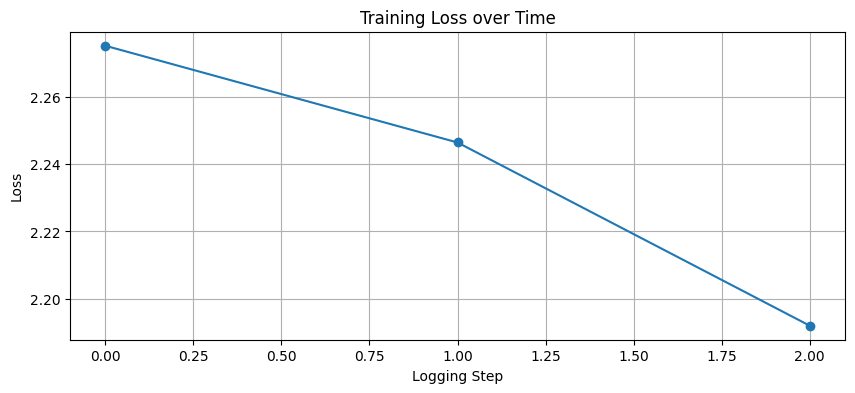

In [24]:
# Plot the training loss over time
log_history = trainer.state.log_history
loss_values = [entry["loss"] for entry in log_history if "loss" in entry]

plt.figure(figsize=(10, 4))
plt.plot(loss_values, marker='o')
plt.title("Training Loss over Time")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Save the model

The folowing code creates a new folder with name `{model_name}_{model_version}` in the `Model` folder and saves the fine-tuned model to the folder.

<font color="Red">Specify the version name of the fine-tuned model to avoid over-writing the existing model.</font>

In [25]:
# Specify version name
model_version = "v1_2epoch"

In [26]:
# Create the folder
model_results_path = os.path.join(model_path, model_name+'_'+model_version)
try:
  os.makedirs(model_results_path, exist_ok=False)
  print(f"Directory {model_results_path} created successfully")
except OSError as error:
  print(f"Directory {model_results_path} already exists. Update the model version to avoid over-writing the existing model")
  assert False

Directory /content/drive/MyDrive/FICO Analytic Challenge/Model/bert-base-uncased_v1_2epoch created successfully


In [27]:
# Save the fine-tuned model
trainer.save_model(model_results_path)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
# Save the tokenizer
tokenizer.save_pretrained(model_results_path)

('/content/drive/MyDrive/FICO Analytic Challenge/Model/bert-base-uncased_v1_2epoch/tokenizer_config.json',
 '/content/drive/MyDrive/FICO Analytic Challenge/Model/bert-base-uncased_v1_2epoch/tokenizer.json')

## Evaluate the fine-tuned model on Test data

Evaluation on a test dataset is needed to measure how well your model performs on data it hasn’t seen during training. The following code evaluates the performance of fine-tuned model on the test dataset.

In [29]:
# Evaluate the fine-tuned model on test data
test_results = trainer.evaluate(eval_dataset=dataset["test"])
display(test_results)

{'eval_loss': 2.1635801792144775,
 'eval_accuracy': 0.2222222222222222,
 'eval_f1': 0.13650793650793652,
 'eval_runtime': 0.8098,
 'eval_samples_per_second': 55.566,
 'eval_steps_per_second': 7.409,
 'epoch': 2.0}